In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!git clone https://github.com/facebookresearch/ssl_watermarking.git

fatal: destination path 'ssl_watermarking' already exists and is not an empty directory.


In [4]:
%cd /content/drive/MyDrive/ssl_watermarking

/content/drive/MyDrive/ssl_watermarking


In [5]:
!pip install pillow==9.5.0
!pip install augly==1.0.0

  Using cached augly-1.0.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached iopath-0.1.10.tar.gz (42 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_magic-0.4.27-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached portalocker-3.1.1-py3-none-any.whl.metadata (8.6 kB)
Using cached augly-1.0.0-py3-none-any.whl (24.3 MB)
Using cached python_magic-0.4.27-py2.py3-none-any.whl (13 kB)
Using cached portalocker-3.1.1-py3-none-any.whl (19 kB)
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=14e0f52c9373c7349bde1f3980b5489d6db3e16612aaa3c71fe6dd9b9a9ac656
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath


In [6]:
import os
import subprocess
import torch

# 경로 설정
base_dir = "/content/drive/MyDrive/ssl_watermarking"
origin_dir = "/content/drive/MyDrive/origin_img"
output_dir = os.path.join(base_dir, "ssl_output")
os.makedirs(output_dir, exist_ok=True)

# 모델 경로
model_path = "/content/drive/MyDrive/ssl_watermarking/models/dino_r50_plus.pth"

# weights_only=False 명시하면 됩니다!
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)

normlayer_path = os.path.join(base_dir, "normlayers", "out2048_yfcc_orig.pth")

# 삽입 실행
command = [
    "python", "main_multibit.py",
    "--data_dir", origin_dir,
    "--model_path", model_path,
    "--normlayer_path", normlayer_path,
    "--output_dir", output_dir,
    "--batch_size", "1",
    "--target_psnr", "38",
    "--num_bits", "64",
    "--evaluate", "False",
    "--save_images", "True",
    "--msg_path", os.path.join(output_dir, "messages.txt")
]

result = subprocess.run(command, capture_output=True, text=True)
print("\n".join(result.stdout.splitlines()[-15:]))  # 마지막 15줄 출력


>>> Saving images into /content/drive/MyDrive/ssl_watermarking/ssl_output/imgs...


In [ ]:
print("🧾 STDOUT (표준 출력)")
print("\n".join(result.stdout.splitlines()[-15:]))

print("\n❗ STDERR (에러 출력)")
print("\n".join(result.stderr.splitlines()[-15:]))


🧾 STDOUT (표준 출력)


❗ STDERR (에러 출력)
python3: can't open file '/content/main_multibit.py': [Errno 2] No such file or directory


***
# 이미지 품질 계산

In [1]:
!pip install scikit-image matplotlib


In [2]:
import os

img_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_output/imgs"

for i in range(50):
    old_name = os.path.join(img_dir, f"{i}_out.png")
    new_name = os.path.join(img_dir, f"{i+1:02}.png")  # → 01.png, 02.png, ...
    if os.path.exists(old_name):
        os.rename(old_name, new_name)

In [3]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

origin_dir = "/content/drive/MyDrive/origin_img/class"
marked_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_output/imgs"

psnr_list = []
ssim_list = []

origin_files = sorted(os.listdir(origin_dir))
marked_files = sorted(os.listdir(marked_dir))

for i in tqdm(range(len(origin_files))):
    orig_img = Image.open(os.path.join(origin_dir, origin_files[i])).convert("RGB")
    marked_img = Image.open(os.path.join(marked_dir, marked_files[i])).convert("RGB")

    # ✅ 강제 리사이즈로 shape 맞추기
    marked_img = marked_img.resize(orig_img.size)

    orig_np = np.array(orig_img).astype(np.uint8)
    marked_np = np.array(marked_img).astype(np.uint8)

    psnr_val = psnr(orig_np, marked_np, data_range=255)
    ssim_val = ssim(orig_np, marked_np, channel_axis=2)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


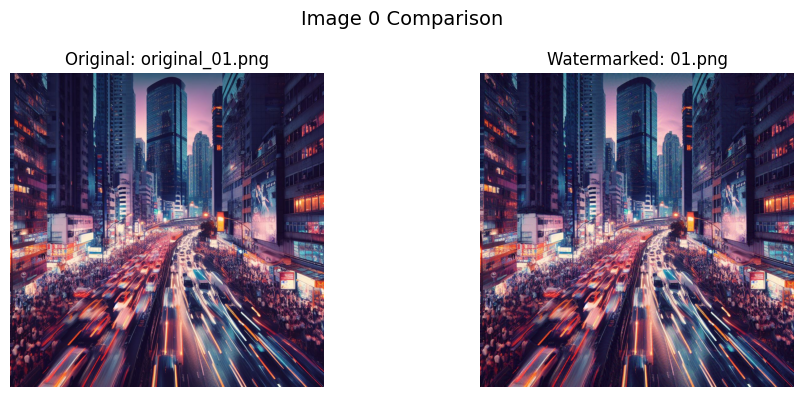

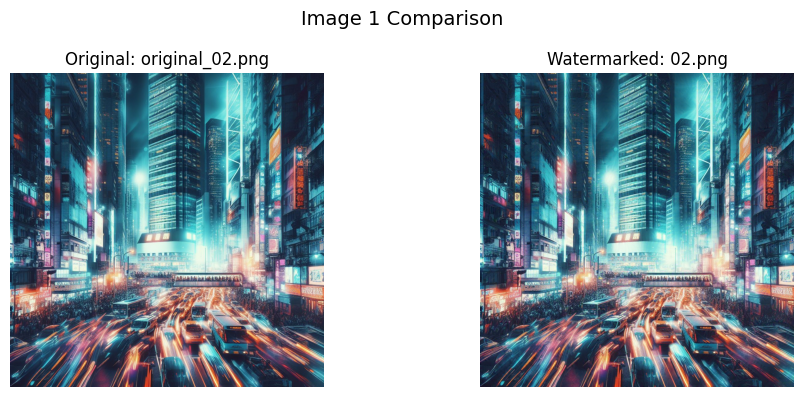

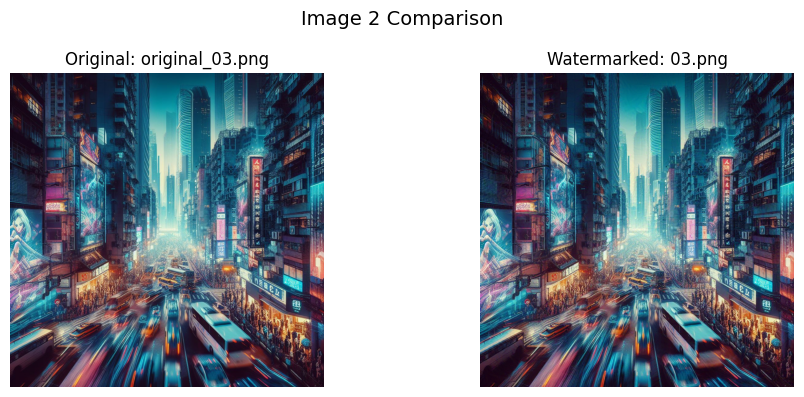

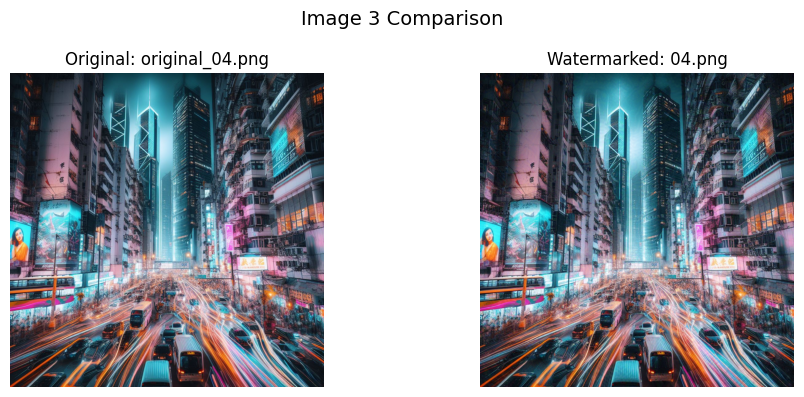

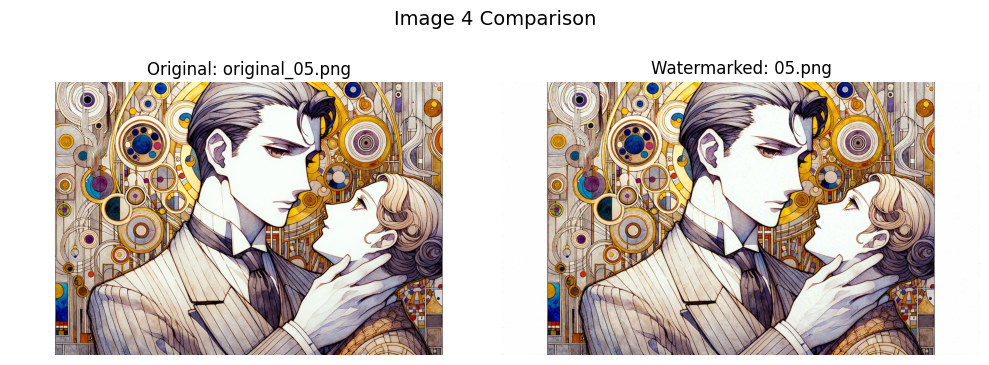

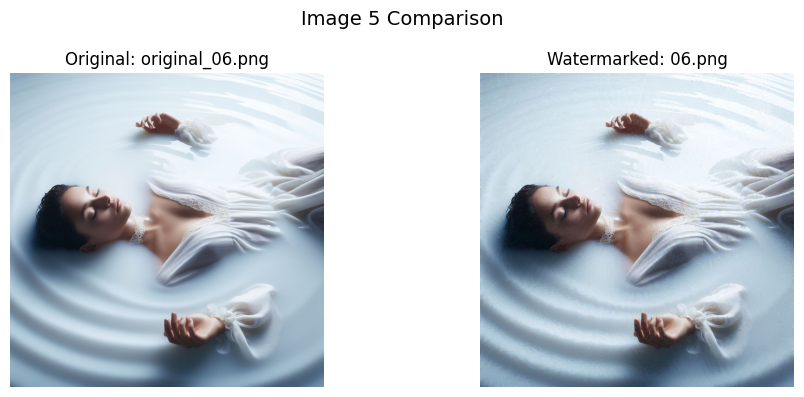

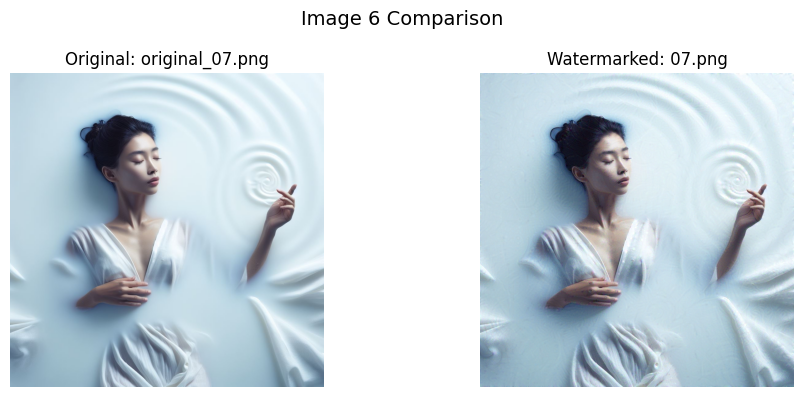

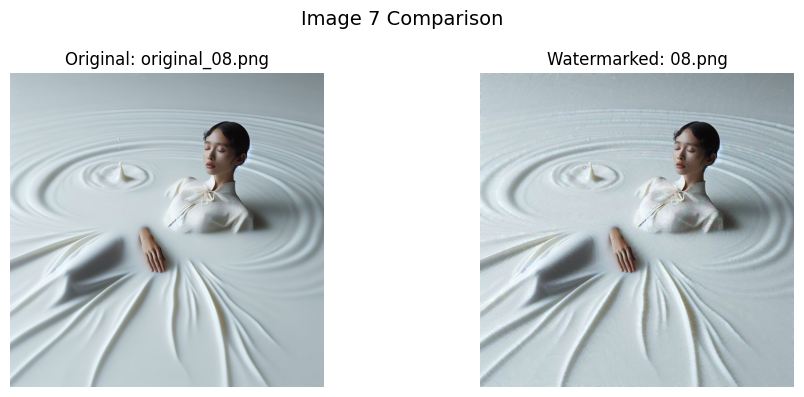

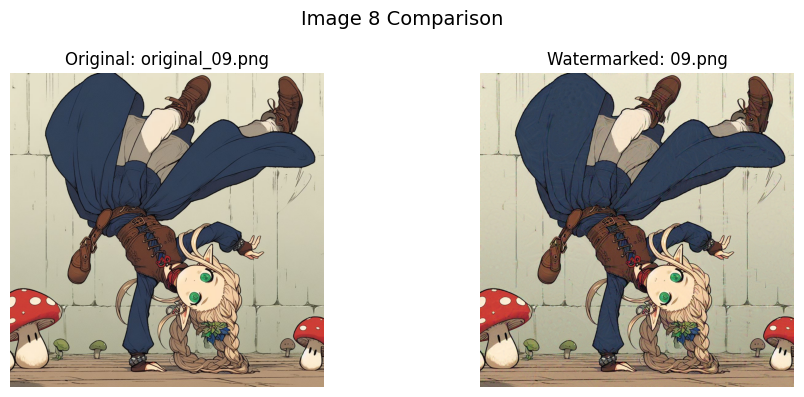

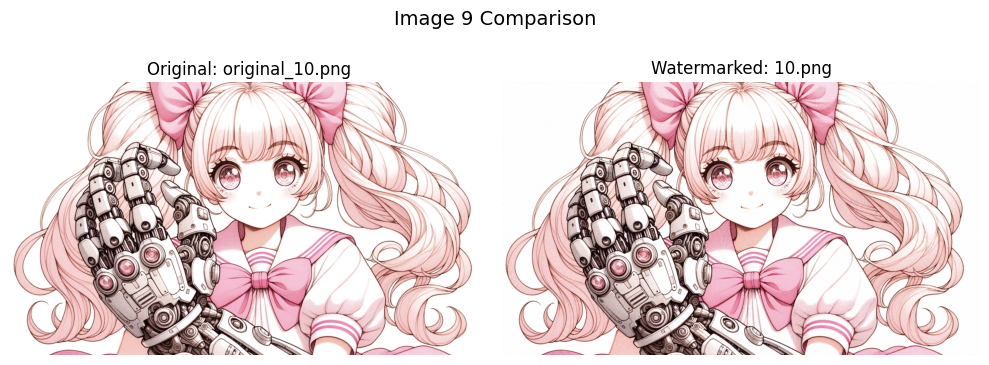

In [4]:
import matplotlib.pyplot as plt

# 몇 장만 볼까요? (예: 앞에서 10장)
num_to_show = 10

for i in range(num_to_show):
    orig_path = os.path.join(origin_dir, origin_files[i])
    marked_path = os.path.join(marked_dir, marked_files[i])

    orig_img = Image.open(orig_path).convert("RGB")
    marked_img = Image.open(marked_path).convert("RGB").resize(orig_img.size)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title(f"Original: {origin_files[i]}")
    axes[0].axis("off")

    axes[1].imshow(marked_img)
    axes[1].set_title(f"Watermarked: {marked_files[i]}")
    axes[1].axis("off")

    plt.suptitle(f"Image {i} Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()


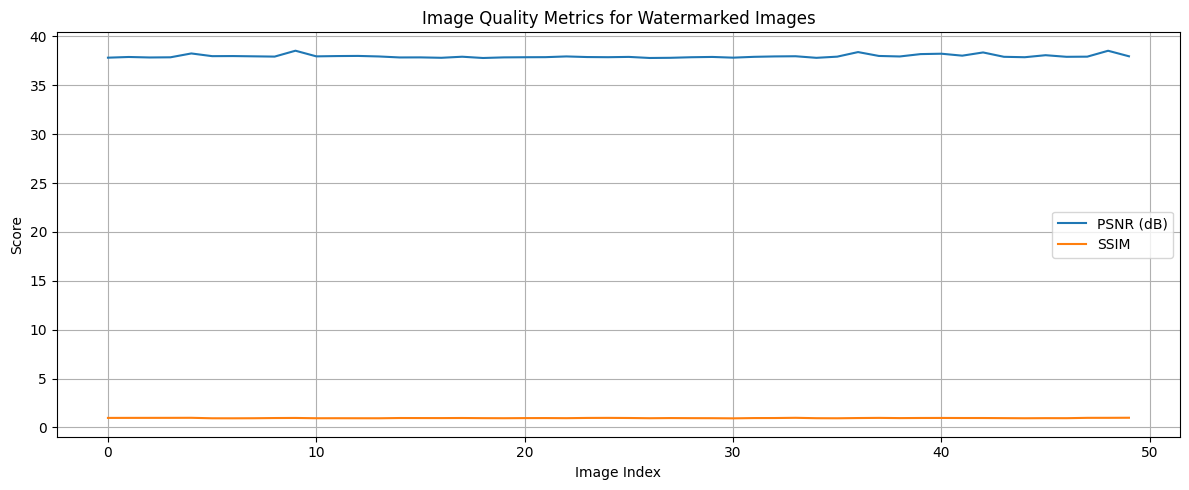

In [5]:
# 그래프
plt.figure(figsize=(12,5))
plt.plot(psnr_list, label="PSNR (dB)")
plt.plot(ssim_list, label="SSIM")
plt.xlabel("Image Index")
plt.ylabel("Score")
plt.title("Image Quality Metrics for Watermarked Images")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

***
# 워터마크 Bit Acc 구하기

In [6]:
import os
import subprocess

# 경로 설정
base_dir = "/content/drive/MyDrive/ssl_watermarking"
output_dir = os.path.join(base_dir, "ssl_eval")
waves_dir = os.path.join(base_dir, "ssl_waves")
carrier_dir = os.path.join(base_dir, "carriers")
message_path = os.path.join(output_dir, "messages.txt")  # 삽입 때 저장된 메시지 위치

model_path = os.path.join(base_dir, "models", "dino_r50_plus.pth")
normlayer_path = os.path.join(base_dir, "normlayers", "out2048_yfcc_orig.pth")

# 디코딩 실행
command = [
    "python", "main_multibit.py",
    "--decode_only", "True",
    "--data_dir", waves_dir,
    "--model_path", model_path,
    "--normlayer_path", normlayer_path,
    "--carrier_dir", carrier_dir,
    "--msg_path", message_path,
    "--output_dir", os.path.join(base_dir, "ssl_decoded"),
    "--num_bits", "64",
    "--verbose", "1"
]

result = subprocess.run(command, cwd="/content/drive/MyDrive/ssl_watermarking",capture_output=True, text=True)
print("\n".join(result.stdout.splitlines()[-20:]))


>>> Building backbone and normalization layer...
>>> Loading carrier from /content/drive/MyDrive/ssl_watermarking/carriers/carrier_64_2048.pth
>>> Decoding watermarks...
Results saved in /content/drive/MyDrive/ssl_watermarking/ssl_decoded/decodings.csv


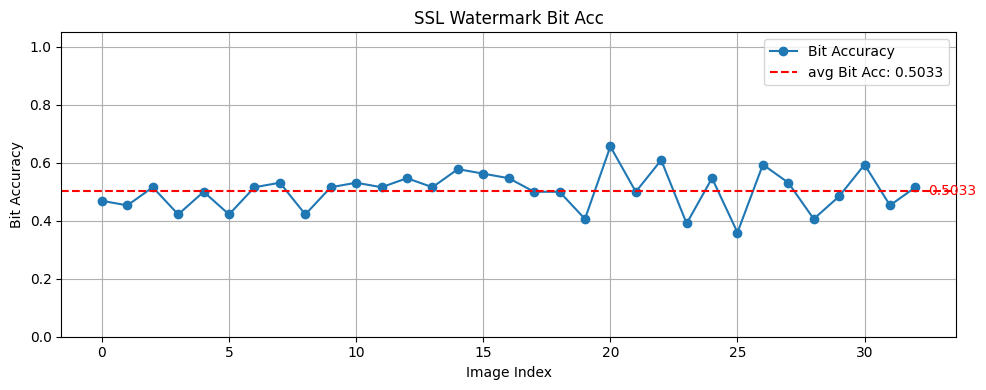

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 경로 지정
csv_path = "/content/drive/MyDrive/ssl_watermarking/ssl_decoded/decodings.csv"
message_path = "/content/drive/MyDrive/ssl_watermarking/ssl_output/messages.txt"

# 데이터 로드
decoded_df = pd.read_csv(csv_path)
with open(message_path, "r") as f:
    original_messages = [line.strip() for line in f.readlines()]

# 복원 메시지와 원본 메시지 비교
bit_acc_list = []
for decoded, gt in zip(decoded_df["msg"], original_messages):
    matches = sum(d == g for d, g in zip(decoded, gt))
    acc = matches / len(gt)
    bit_acc_list.append(acc)

decoded_df["bit_acc"] = bit_acc_list
mean_acc = sum(bit_acc_list) / len(bit_acc_list)

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(decoded_df["index"], decoded_df["bit_acc"], marker='o', label="Bit Accuracy", color='tab:blue')
plt.axhline(y=mean_acc, color='red', linestyle='--', label=f"avg Bit Acc: {mean_acc:.4f}")
plt.text(decoded_df["index"].max() + 0.5, mean_acc, f"{mean_acc:.4f}", color='red', va='center')

plt.xlabel("Image Index")
plt.ylabel("Bit Accuracy")
plt.title("SSL Watermark Bit Acc")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
